In [1]:
# Do not reload
import sys, os
sys.path.append("../")
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import DATA_PATH, MODELS_PATH
from src.common import input_keys, agg_trns, pickle_model_obj, unpickle_model_obj
from src.preprocess import Preprocessor
from src.model import ForestWrapper

%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv(DATA_PATH / 'generated_ad_data.csv.gz', sep=';', compression='gzip', parse_dates=[input_keys.TIME_KEY])
df.head()

,REQUEST_TIME,DEVICE_IP,DEVICE_IFA,GEO_CURRENT_CITY,DEVICE_LANGUAGE,GENERATED_AS_BOT
0,2022-12-23 00:27:35.256700,205.164.35.49,eda3bc5f-dfa8-4ecf-a23f-802d60c83da8,Holon,ar,1
1,2022-12-23 00:28:51.244001,201.94.194.219,eda3bc5f-dfa8-4ecf-a23f-802d60c83da8,Holon,ar,1
2,2022-12-23 00:26:41.236577,201.94.194.219,eda3bc5f-dfa8-4ecf-a23f-802d60c83da8,Holon,ar,1
3,2022-12-23 00:27:31.349346,214.146.246.234,eda3bc5f-dfa8-4ecf-a23f-802d60c83da8,Holon,ar,1
4,2022-12-23 00:26:13.451773,201.94.194.219,eda3bc5f-dfa8-4ecf-a23f-802d60c83da8,Holon,ar,1


In [4]:
preprocessor = Preprocessor(input_keys, agg_trns)
final_df = preprocessor.fit_transform(df)

pickle_model_obj(preprocessor, 'preprocessor.pkl')
    
final_df['BOT'] = df.groupby(input_keys.PRIMARY_KEY)['GENERATED_AS_BOT'].agg(min).values

D:\Data\Data Science\Interviews\Intelos\sleep-detector\sleep-detector\src\preprocess.py:101: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_feats.drop(columns=self.input_keys.PRIMARY_KEY)


After feature engineering:

In [5]:
final_df.head()

,DEVICE_IFA,0,1,2,3,4,5,6,7,8,...,CUMNORM_21,CUMNORM_22,"(TIME_DIFF, mean)","(TIME_DIFF, max)","(TIME_DIFF, min)","(TIME_DIFF, std)","(DEVICE_IP, nunique)","(GEO_CURRENT_CITY, nunique)","(DEVICE_LANGUAGE, nunique)",BOT
0,003b4a70-ddd0-48d6-9aba-37560ef7d063,2.0,2.0,3.0,3.0,4.0,5.0,5.0,6.0,6.0,...,0.539877,0.588957,531.352799,9011.836049,0.383595,891.135118,3,1,1,1
1,0054d97a-32e0-4b4c-922a-f13dc69e16b3,2.0,3.0,5.0,6.0,5.0,1.0,3.0,0.0,2.0,...,0.898795,0.942169,208.066648,6580.581423,0.430871,475.214429,1,1,1,1
2,0073d498-2992-42b8-bf7a-bb60b1d77016,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1.0,...,0.857143,0.928571,1543.088615,17070.776899,18.015052,2917.283496,1,1,1,0
3,0096b5fd-bd34-452e-9339-db41481887a3,42.0,13.0,22.0,26.0,28.0,14.0,13.0,7.0,6.0,...,0.823353,0.862275,246.796282,6759.022317,0.002137,1000.745017,1,1,1,1
4,00c684f1-5c8a-416a-97cf-89a79c668ab5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.979167,1.000000,1057.524812,5787.422348,0.405475,1202.641928,2,1,1,0


# Visualizations

The average hourly activity profiles are different for bots and humans:

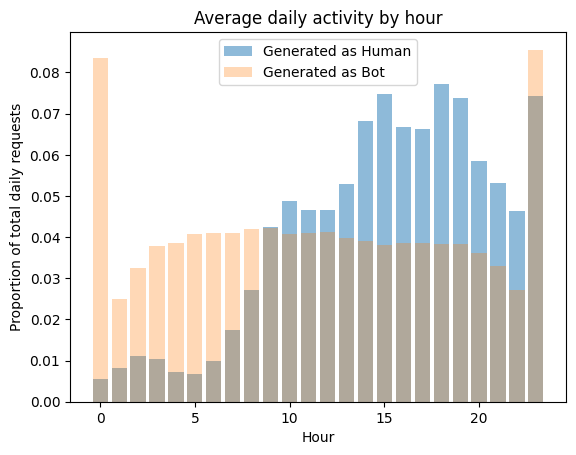

In [6]:
norm_df = final_df[[f'NORM_{i}' for i in range(24)]]

plt.title('Average daily activity by hour')
plt.bar(range(24), norm_df[final_df['BOT']==0].mean(axis=0), alpha=0.5, label='Generated as Human')
plt.bar(range(24), norm_df[final_df['BOT']==1].mean(axis=0), alpha=0.3, label='Generated as Bot')
plt.ylabel('Proportion of total daily requests')
plt.xlabel('Hour')
plt.legend()
plt.show()

Bots:
- have much less number of hours with zero activity;
- can have large total number of requests daily;
- have less average time difference between consecutive requests;
- have less variance (std) in the time difference between consecutive requests.

Illustrations:

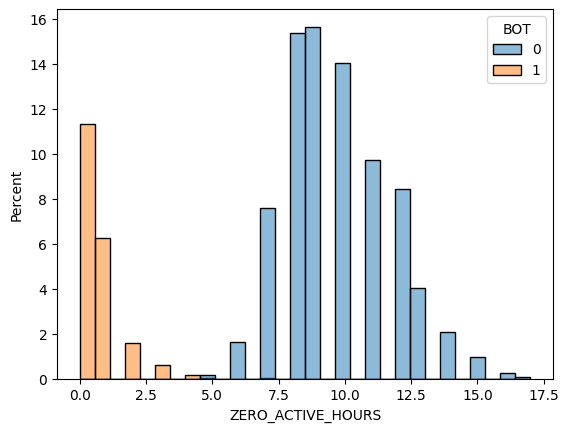

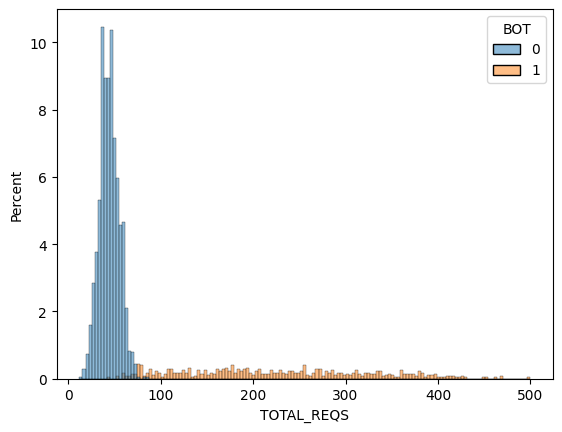

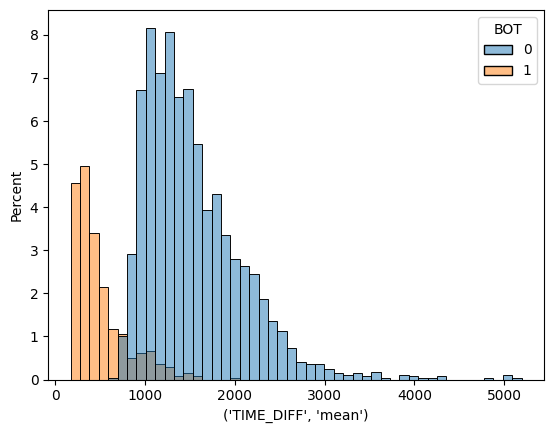

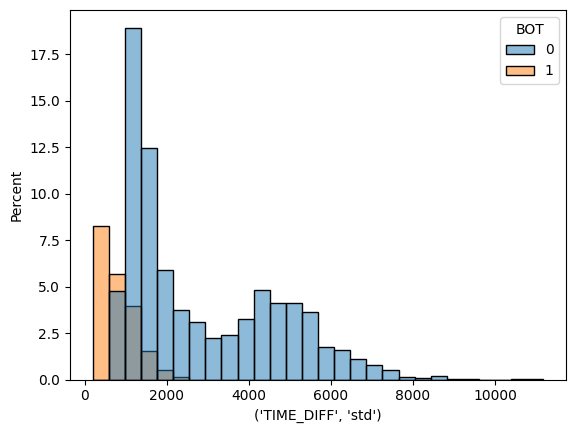

In [7]:
features = ['ZERO_ACTIVE_HOURS', 'TOTAL_REQS', ('TIME_DIFF', 'mean'), ('TIME_DIFF', 'std')]
for col in features:
    sns.histplot(x=final_df[col], hue=final_df['BOT'], stat='percent')
    plt.show()

Graphs provided above show that features produced can indeed be used to identify abnormal sleeping activity.

# Modelling

In [8]:
clf = ForestWrapper(n_estimators=300, contamination=0.2)
train_preds = clf.fit_predict(final_df.drop(columns=[input_keys.PRIMARY_KEY, 'BOT']))

pickle_model_obj(clf, 'forest.pkl')

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [9]:
print('Overall accuracy on train part:', ((train_preds < 0) == final_df['BOT']).mean())
print('Recall on train part:', (train_preds[final_df['BOT'] == 1] < 0).mean())
print('Precision on train part:', final_df[train_preds < 0]['BOT'].mean())

Overall accuracy on train part: 0.9318016046681254
Recall on train part: 0.8290909090909091
Precision on train part: 0.8306010928961749


# Checking on test data (generated by the same process):

In [10]:
test_df = pd.read_csv(
    DATA_PATH / 'generated_ad_data_test.csv.gz', sep=';', compression='gzip', parse_dates=[input_keys.TIME_KEY]
)
test_df.head()

,REQUEST_TIME,DEVICE_IP,DEVICE_IFA,GEO_CURRENT_CITY,DEVICE_LANGUAGE,GENERATED_AS_BOT
0,2022-12-19 00:03:17.359080,174.194.151.168,9e0f8adf-dd49-415b-9af2-78f409cf6fde,Tel Aviv,he,1
1,2022-12-19 00:42:25.124704,174.194.151.168,9e0f8adf-dd49-415b-9af2-78f409cf6fde,Tel Aviv,he,1
2,2022-12-19 00:04:55.753653,63.116.193.184,9e0f8adf-dd49-415b-9af2-78f409cf6fde,Tel Aviv,he,1
3,2022-12-19 01:23:45.167708,62.180.0.153,9e0f8adf-dd49-415b-9af2-78f409cf6fde,Tel Aviv,he,1
4,2022-12-19 01:53:35.297016,62.180.0.153,9e0f8adf-dd49-415b-9af2-78f409cf6fde,Tel Aviv,he,1


In [11]:
preprocessor = unpickle_model_obj('preprocessor.pkl')
clf = unpickle_model_obj('forest.pkl')


final_test_df = preprocessor.transform(test_df)
final_test_df['BOT'] = test_df.groupby(input_keys.PRIMARY_KEY)['GENERATED_AS_BOT'].agg(min).values

D:\Data\Data Science\Interviews\Intelos\sleep-detector\sleep-detector\src\preprocess.py:101: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_feats.drop(columns=self.input_keys.PRIMARY_KEY)


In [12]:
test_preds = clf.predict(final_test_df.drop(columns=[input_keys.PRIMARY_KEY, 'BOT']))

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [13]:
print('Overall accuracy on test part:', ((test_preds < 0) == final_test_df['BOT']).mean())
print('Recall on test part:', (test_preds[final_test_df['BOT'] == 1] < 0).mean())
print('Precision on test part:', final_test_df[test_preds < 0]['BOT'].mean())

Overall accuracy on test part: 0.9313543599257885
Recall on test part: 0.7684210526315789
Precision on test part: 0.8295454545454546


# Visualize test performance

In [14]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans

In [15]:
tsne = TSNE(n_components=2, perplexity=35)
data_2d = tsne.fit_transform(final_test_df.drop(columns=[input_keys.PRIMARY_KEY]))

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


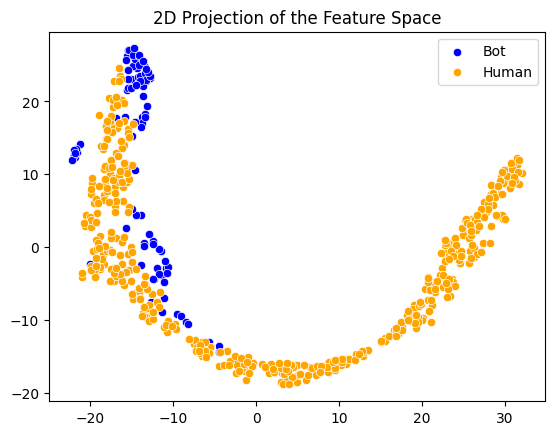

In [16]:
plt.title('2D Projection of the Feature Space')
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 1][:, 0], y=data_2d[final_test_df['BOT'] == 1][:, 1], color='blue', label='Bot'
)
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 0][:, 0], y=data_2d[final_test_df['BOT'] == 0][:, 1], color='orange', label='Human'
)
plt.legend()
plt.show()

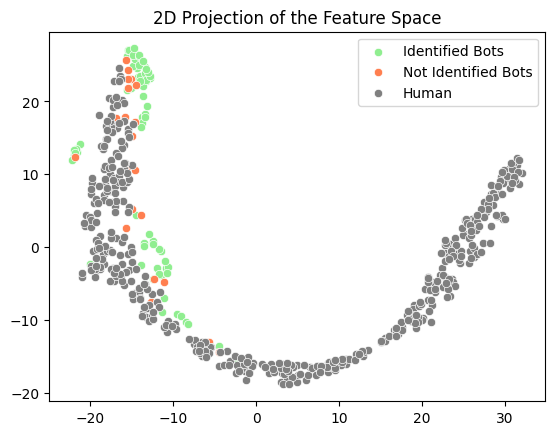

In [17]:
plt.title('2D Projection of the Feature Space')
sns.scatterplot(
    x=data_2d[(final_test_df['BOT'] == 1) & (test_preds < 0)][:, 0], y=data_2d[(final_test_df['BOT'] == 1) & (test_preds < 0)][:, 1], 
    color='lightgreen', label='Identified Bots')
sns.scatterplot(
    x=data_2d[(final_test_df['BOT'] == 1) & (test_preds >= 0)][:, 0], y=data_2d[(final_test_df['BOT'] == 1) & (test_preds >= 0)][:, 1], 
    color='coral', label='Not Identified Bots')
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 0][:, 0], y=data_2d[final_test_df['BOT'] == 0][:, 1], color='grey', label='Human'
)

plt.legend()
plt.show()